# Chapter 3 - Developing Templates

Generating SoftMax distributions from normals could get quite tedious – for any sufficiently complicated shape, the number of normals to be used could be excessive. Let's add a layer of abstraction onto all our work.

##Polygon Construction

We can put everything together from all we've talked about (shifting the distribution and generating weights from normals) to a more tangible process: generating a softmax distribution from a [polytope](http://en.wikipedia.org/wiki/Polytope). Let's motivate this with an example first.

Imagine you worked at the Pentagon as an HRI researcher. One day, while pondering the nature of language, you happened to look out your window and spot an intruder. If you called a human security officer, you might say something like, "I see an intruder in front of the Heliport facade." We can use our SoftMax classifier to translate this same sentence for a security bot to understand.

First, we'd need to divide the space in a similar way we did for the Pac-Man problem:

<img src="https://raw.githubusercontent.com/COHRINT/cops_and_robots/master/notebooks/softmax/img/pentagon.png" alt="Pentagon space division" width="500px">

As opposed to our Pac-Man problem, we can't assign weights by inspection. Instead, we'll use our weights-from-normals tactic to generate our weights for each class, and our shifted bias tactic to place those weights appropriately.

### Step 1: Define Polytope
We can use a geometry library like [Shapely](http://toblerity.org/shapely/shapely.html) to define custom polytopes (in this case, a pentagon). For a quick way to get ideal pentagon vertex coordinates, you can either calculate them by hand or use [some online tools](http://www.mathsisfun.com/geometry/pentagon.html). 

Let's try a pentagon with the following coordinates (starting at the corner between the South Parking Entrance and the Heliport Facade):

$$
\begin{align}
P_1 &= (P_{1x}, P_{1y}) = (-1.90,-0.93) \\
P_2 &= (-1.40,1.45) \\
P_3 &= (1.03,1.71) \\
P_4 &= (2.02,-0.51) \\
P_5 &= (0.21,-2.15) \\
\end{align}
$$


### Step 2: Get Normals
We want to get six classes, so we'd like to specify $\frac{6(6-1)}{2} = 15$ normal vectors in order to use our transformation matrix $A$. That is, we'd like:

$$
\mathbf{N} = \begin{bmatrix}
\mathbf{n}_{0,1}^T \\
\mathbf{n}_{0,2}^T \\
\mathbf{n}_{0,3}^T \\
\mathbf{n}_{0,4}^T \\
\mathbf{n}_{0,5}^T \\
\mathbf{n}_{1,2}^T \\
\mathbf{n}_{1,3}^T \\
\mathbf{n}_{1,4}^T \\
\mathbf{n}_{1,5}^T \\
\mathbf{n}_{2,3}^T \\
\mathbf{n}_{2,4}^T \\
\mathbf{n}_{2,5}^T \\
\mathbf{n}_{3,4}^T \\
\mathbf{n}_{3,5}^T \\
\mathbf{n}_{4,5}^T \\
\end{bmatrix} 
= \begin{bmatrix}
-1 & 1 & 0 & 0 & 0 & 0 \\
-1 & 0 & 1 & 0 & 0 & 0 \\
-1 & 0 & 0 & 1 & 0 & 0 \\
-1 & 0 & 0 & 0 & 1 & 0 \\
-1 & 0 & 0 & 0 & 0 & 1 \\
0 & -1 & 1 & 0 & 0 & 0 \\
0 & -1 & 0 & 1 & 0 & 0 \\
0 & -1 & 0 & 0 & 1 & 0 \\
0 & -1 & 0 & 0 & 0 & 1 \\
0 & 0 & -1 & 1 & 0 & 0 \\
0 & 0 & -1 & 0 & 1 & 0 \\
0 & 0 & -1 & 0 & 0 & 1 \\
0 & 0 & 0 & -1 & 1 & 0 \\
0 & 0 & 0 & -1 & 0 & 1 \\
0 & 0 & 0 & 0 & -1 & 1 \\
\end{bmatrix}
\begin{bmatrix}
\mathbf{w}_{0}^T \\
\mathbf{w}_{1}^T \\
\mathbf{w}_{2}^T \\
\mathbf{w}_{3}^T \\
\mathbf{w}_{4}^T \\
\mathbf{w}_{5}^T \\
\end{bmatrix} 
= \mathbf{A}\mathbf{W}
$$

Where $\mathbf{n}_{0,1}$ is the boundary between the interior and the South Parking Entrance, and so on. Some boundaries are obvious ($\mathbf{n}_{0,1}$ through $\mathbf{n}_{0,5}$ are simply the lines found at each consecutive point on the pentagon), but some aren't. Let's plot the normals we'd expect to see: 



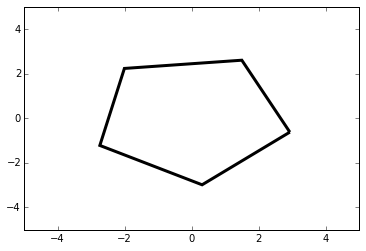

In [160]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from descartes.patch import PolygonPatch

n_sides = 5
origin = (0,0)
theta = -np.pi/15  # approximately
max_r = 3

x = [max_r * np.cos(2 * np.pi * n / n_sides + theta) + origin[0]
         for n in range(n_sides)]
y = [max_r * np.sin(2 * np.pi * n / n_sides + theta) + origin[1]
     for n in range(n_sides)]
pts = zip(x,y)
pentagon = Polygon(pts)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
patch = PolygonPatch(pentagon, facecolor='none', edgecolor='black',
                     linewidth=3, zorder=2)
ax.add_patch(patch)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
plt.show()



Once we have our vertex coordinates.:

$$
\mathbf{n}_{i,j} = \begin{bmatrix}P_{jx} - P_{ix} & P_{jy} - P_{iy} & 0\end{bmatrix}^T \times \begin{bmatrix}0 & 0 & 1\end{bmatrix}^T
$$

Which should be returned to $\mathbb{R}^2$ by removing the z-component, so we get:

$$
\begin{align}
\mathbf{n}_{1,2} &= (n_{12x},n_{12y}) =  (0.98, -0.21) \\
\mathbf{n}_{2,3} &= (0.11, -0.99) \\
\mathbf{n}_{3,4} &= (-0.91, -0.41) \\
\mathbf{n}_{4,5} &= (-0.67, 0.74) \\
\mathbf{n}_{5,1} &= (0.50, 0.87) \\
\end{align}
$$

Let's see what we get if we plug these into our weights-from-normals function:

[[ 0.    -0.352  0.778]
 [ 0.     0.628  0.568]
 [ 0.     0.738 -0.422]
 [ 0.    -0.172 -0.832]
 [ 0.    -0.842 -0.092]]


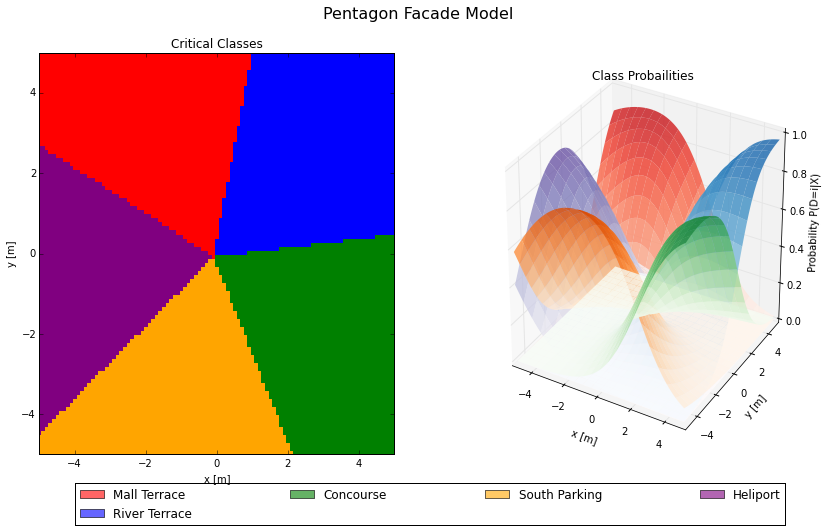

In [28]:
n = np.array([[0, 0.98, -0.21],
              [0, 0.11, -0.99],
              [0, -0.91, -0.41],
              [0, -0.67, 0.74],
              [0, 0.49, 0.87]])
A = np.roll(np.eye(5,5),1,axis=1) - np.eye(5,5)
w = np.dot(np.linalg.pinv(A),n) 
print(w)

labels = ['Mall Terrace','River Terrace','Concourse','South Parking','Heliport','Interior']
pentagon = SoftMax(weights=w, class_labels=labels)
# Note that SoftMax(normals=n, class_labels=labels) works too
pentagon.plot(title='Pentagon Facade Model')

Well, it's a start, but we need to include our interior as well. 

### Step 3: Get Weights from Offset Normals
It's helpful to think of our interior as the relative ground for all other classes, because then we can start biasing other classes with respect to our interior class. Let's use the minimum distance from each wall to our origin as a bias parameter for each class, that is:

$$
w_{i,b} = -\sqrt{(P_{ix,min} - 0)^2 + (P_{iy,min} - 0)^2}
$$

Note that we include a negative sign in front of the square root because we want to scale each class's probability down with respect to the probability of the interior (which has a bias term of 0). We get the following biases:

$$
\begin{align}
w_{1,b} = -1.67 \\
w_{2,b} = -1.59 \\
w_{3,b} = -1.63 \\
w_{4,b} = -1.73 \\
w_{5,b} = -1.75 \\
\end{align}
$$

[[-1.67  -0.352  0.778]
 [-1.59   0.628  0.568]
 [-1.63   0.738 -0.422]
 [-1.73  -0.172 -0.832]
 [-1.75  -0.842 -0.092]
 [ 0.     0.     0.   ]]


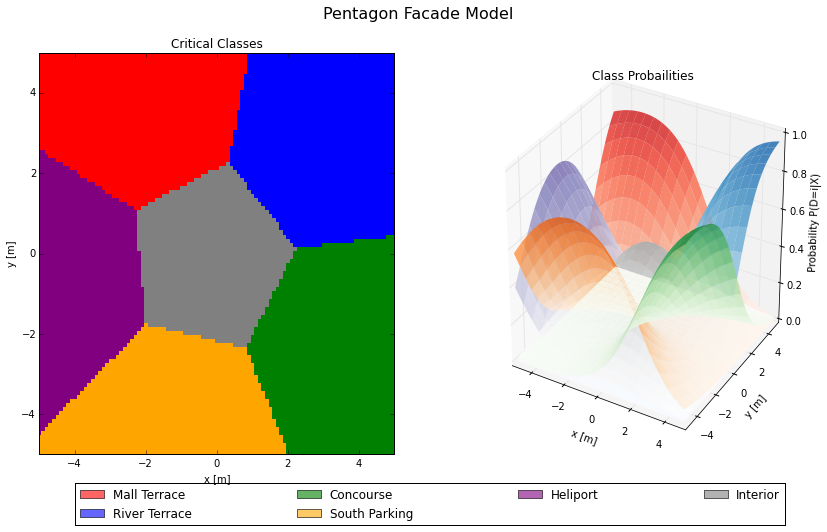

In [30]:
w[0,0] = -1.67
w[1,0] = -1.59
w[2,0] = -1.63
w[3,0] = -1.73
w[4,0] = -1.75
new_w = np.vstack((w, np.zeros(3)))  # Append the weights for the new interior class
print(new_w)

pentagon = SoftMax(weights=new_w, class_labels=labels)
pentagon.plot(title='Pentagon Facade Model')

Great! We've successfully decomposed the space around the Pentagon, so we can tell the automatic security bots where the suspect is without having to pull out a map of the Pentagon and show them directly where on the map our intruder may be. That is, we've replaced communication of specific coordinates with the communication of 'zones' formed by spatial relationships to landmarks.

However, the methodology build up to this point doesn't work for all cases. For instance: what happens if we want to use a non-symmetric shape to develop a SoftMax model? [Chapter 3](03_mms.ipynb) will dive into some of these pitfalls and how to get around them

In [1]:
from shapely.geometry import Polygon
import numpy as np

polygon = Polygon(((-1.8996,-0.92915),
                   (-1.395,1.4523),
                   (1.0256,1.7093),
                   (2.018,-0.51393),
                   (0.21001,-2.145),))
pts = polygon.exterior.coords[:]
normals = np.zeros((len(pts) - 1, 2))
biases = np.zeros(len(pts) - 1)
for i in range(len(pts) - 1):
    slope = (pts[i + 1][1] - pts[i][1]) / (pts[i + 1][0] - pts[i][0])
    normals[i] = np.array((-slope, 1))
    biases[i] = pts[i][1] - slope * pts[i][0]
print(normals)
print(biases)

[[-4.71948078  1.        ]
 [-0.10617202  1.        ]
 [ 2.24025595  1.        ]
 [-0.90214548  1.        ]
 [ 0.57633875  1.        ]]
[ 8.03597568  1.60040997  4.0069065  -2.33445957 -2.0239631 ]


##From Polygons to Polytopes

In [6]:
from collada import Collada
import numpy as np
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

lim_ = 50 # Fleming
mesh = Collada('/Users/nick/Downloads/FlemingLaw.dae')
# lim_ = 250 # Pentagon
# mesh = Collada('/Users/nick/Downloads/Pentagon.dae')

mpu = mesh.assetInfo.unitmeter # how many real-world meters are in one distance unit

# Grab all model vertices
geometries = mesh.geometries
primitives = [ _.primitives for _ in geometries]
trisets = [ _[0] for _ in primitives]
vertices = [ a.vertex for a in trisets]
vertices = np.asarray(vertices) * mpu

# Find convex hull
verts = np.zeros([1,3])
for vert in vertices:
    verts = np.vstack((verts,vert))
hull = ConvexHull(verts)

# Get all facets (faces) of the convex hull
facets = []
for simplex in hull.simplices:
    facet = [(verts[simplex[0],0],verts[simplex[0],1],verts[simplex[0],2]),
             (verts[simplex[1],0],verts[simplex[1],1],verts[simplex[1],2]),
             (verts[simplex[2],0],verts[simplex[2],1],verts[simplex[2],2]),
             ]    
    facets.append(facet)

# Plot vertices and convex hull
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(verts[:,0], verts[:,1],verts[:,2])
ax.add_collection3d(Poly3DCollection(facets, alpha=0.5))

ax.auto_scale_xyz([-lim_, lim_], [-lim_, lim_], [-lim_, lim_]) 
plt.show()


In [17]:
from IPython.core.display import HTML

# Borrowed style from Probabilistic Programming and Bayesian Methods for Hackers
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()